# Casestudy CRC :  SRM colorectal cancer data

This is case study CRC in  in this paper. The dataset is available at https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4568950/. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import set_matplotlib_formats
from matplotlib.lines import Line2D
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.collections import LineCollection
import json


set_matplotlib_formats("svg")


/var/folders/sp/pn9txhp11mn2pyld318tpy080000gn/T/ipykernel_44052/1803211305.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg")


Plasma samples were subjected to parallel N-glycoprotein
extraction in a 96-well format, followed by targeted Selected Reaction Monitoring (SRM)
quantification of 67 candidate proteins by SRM. PSMs were summarized into protein-level
summaries by MSstatsTMT. 

### Get pilot/historical data from past similar experiment

In [3]:
data = pd.read_csv('../casestudy/crc/data/crc_silvia_data.csv')
data.head()

,A1AG2,AFM,AHSG,ANT3,AOC3,APOB,ATRN,BTD,C20orf3,CADM1,...,Q5JNX2,SERPINA1,SERPINA3,SERPINA6,SERPINA7,THBS1,TIMP1,VTN,VWF,Condition
0,14.238157,16.103019,19.951792,17.207936,10.032169,15.544774,14.383388,16.283071,10.667779,9.653029,...,19.028130,18.061091,14.218036,15.796849,13.581848,13.995686,11.578754,12.081352,10.661031,CRC
1,15.024111,16.020714,19.715919,17.297900,9.034144,15.131883,13.981723,16.249189,10.703279,9.624991,...,19.862536,17.610188,14.832327,15.815397,13.138445,13.707714,11.960974,12.838407,10.778432,CRC
2,15.631364,16.143800,19.710849,17.596254,10.381880,15.955302,14.635355,16.499158,11.183873,10.323191,...,19.501773,18.539972,15.308726,16.401770,13.742330,15.636962,12.155842,12.313155,11.185271,CRC
3,15.401365,16.276415,19.704377,17.422504,9.502960,15.714932,14.060700,16.277732,9.972982,9.994209,...,19.984664,17.401414,14.254241,16.310491,13.936894,15.517268,12.379265,10.679166,10.887855,CRC
4,16.003158,16.958207,20.420334,17.988199,9.648502,16.247330,14.203595,16.541422,12.581556,9.607492,...,20.467453,17.448008,16.231911,16.485833,14.167134,15.129106,12.169116,14.506106,11.254175,CRC


In [6]:
corr_matrix = data.corr().abs()
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))

In [7]:
# Extract upper triangular part of the correlation matrix (excluding diagonal)
upper_triangular = correlation_matrix.where(
    pd.np.triu(pd.np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find the pairs of columns with the highest correlation coefficients
highest_correlated_pairs = upper_triangular.unstack().sort_values(ascending=False).dropna()

# Get the top correlated pairs
top_correlated_pairs = highest_correlated_pairs.head(20)

# Extract the column names from the top correlated pairs
top_correlated_cols = [pair[0] for pair in top_correlated_pairs.index] + [pair[1] for pair in top_correlated_pairs.index]

# Remove duplicates and keep the unique column names
top_correlated_cols = list(set(top_correlated_cols))

# Print the list of top correlated columns
print("Top correlated columns:", top_correlated_cols)

# Filter the correlation matrix to include only the top correlated columns
correlation_matrix_top = correlation_matrix.loc[top_correlated_cols, top_correlated_cols]

# Print out the correlation matrix for the top correlated columns
print("\nCorrelation matrix for top correlated columns:")
print(correlation_matrix_top)


Top correlated columns: ['ECM1', 'SERPINA3', 'A1AG2', 'DKFZp686N02209', 'PON1', 'CP', 'SERPINA6', 'ORM1', 'ATRN', 'CFH', 'ITIH4', 'SERPINA1']

Correlation matrix for top correlated columns:
                    ECM1  SERPINA3     A1AG2  DKFZp686N02209      PON1  \
ECM1            1.000000  0.463095  0.277065       -0.014304  0.294923   
SERPINA3        0.463095  1.000000  0.779798        0.542713  0.748713   
A1AG2           0.277065  0.779798  1.000000        0.653043  0.722511   
DKFZp686N02209 -0.014304  0.542713  0.653043        1.000000  0.666242   
PON1            0.294923  0.748713  0.722511        0.666242  1.000000   
CP              0.201350  0.568298  0.729893        0.758072  0.611833   
SERPINA6        0.254358  0.747589  0.769517        0.697495  0.806955   
ORM1            0.168616  0.729118  0.851447        0.673552  0.624045   
ATRN            0.123692  0.676450  0.782921        0.813717  0.805140   
CFH             0.803208  0.434301  0.177461       -0.112793  0.167368

/var/folders/sp/pn9txhp11mn2pyld318tpy080000gn/T/ipykernel_3105/2229610576.py:11: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  pd.np.triu(pd.np.ones(correlation_matrix.shape), k=1).astype(bool))


## Simulating realistic data using copula model 

,A1AG2,AFM,AHSG,ANT3,AOC3,APOB,ATRN,BTD,C20orf3,CADM1,...,Q5JNX2,SERPINA1,SERPINA3,SERPINA6,SERPINA7,THBS1,TIMP1,VTN,VWF,Condition
0,14.238157,16.103019,19.951792,17.207936,10.032169,15.544774,14.383388,16.283071,10.667779,9.653029,...,19.028130,18.061091,14.218036,15.796849,13.581848,13.995686,11.578754,12.081352,10.661031,CRC
1,15.024111,16.020714,19.715919,17.297900,9.034144,15.131883,13.981723,16.249189,10.703279,9.624991,...,19.862536,17.610188,14.832327,15.815397,13.138445,13.707714,11.960974,12.838407,10.778432,CRC
2,15.631364,16.143800,19.710849,17.596254,10.381880,15.955302,14.635355,16.499158,11.183873,10.323191,...,19.501773,18.539972,15.308726,16.401770,13.742330,15.636962,12.155842,12.313155,11.185271,CRC
3,15.401365,16.276415,19.704377,17.422504,9.502960,15.714932,14.060700,16.277732,9.972982,9.994209,...,19.984664,17.401414,14.254241,16.310491,13.936894,15.517268,12.379265,10.679166,10.887855,CRC
4,16.003158,16.958207,20.420334,17.988199,9.648502,16.247330,14.203595,16.541422,12.581556,9.607492,...,20.467453,17.448008,16.231911,16.485833,14.167134,15.129106,12.169116,14.506106,11.254175,CRC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,14.442917,15.990122,18.665888,16.506105,9.325916,14.745428,13.072122,15.534248,10.767566,9.142328,...,19.185454,16.173700,13.396709,14.815274,12.338600,15.691712,11.984285,11.879767,11.062184,Healthy
196,15.116044,16.625768,19.475982,17.245004,9.258360,15.141649,13.424602,15.977121,9.889204,9.298522,...,20.052715,16.286212,12.785561,15.497808,13.122072,13.001543,11.816094,12.012430,10.250246,Healthy
197,15.041488,15.224106,18.525146,16.235877,9.284527,14.812296,13.922798,14.939264,10.622075,8.846313,...,18.668108,17.149908,11.122248,15.228195,11.783661,13.346080,11.176881,12.438623,9.410451,Healthy
198,13.922867,16.388432,19.199723,16.204601,9.089451,14.572485,12.838552,15.439934,9.883794,8.043888,...,19.585959,15.788897,12.577409,14.677995,12.614804,14.596866,11.905893,10.916887,10.700179,Healthy


In [ ]:
dataset = df_with_0

from copulas.multivariate import GaussianMultivariate

for i in range(100):
    model = GaussianMultivariate()
    model.fit(dataset)

    synthetic = model.sample(len(dataset))
#     synthetic.to_csv('crc/copula/crc0_gm_copula_'+str(i)+'.csv',index=False)


## Step 3: Evaluation. Evaluating the realism of simulated data

#### Visual Metrics

#### Statistical Metrics

#### Machine Learning Efficacy

#### Similarity Score

## Step 4: Planning. Use simulations to plan future experiments


#### Class Prediction

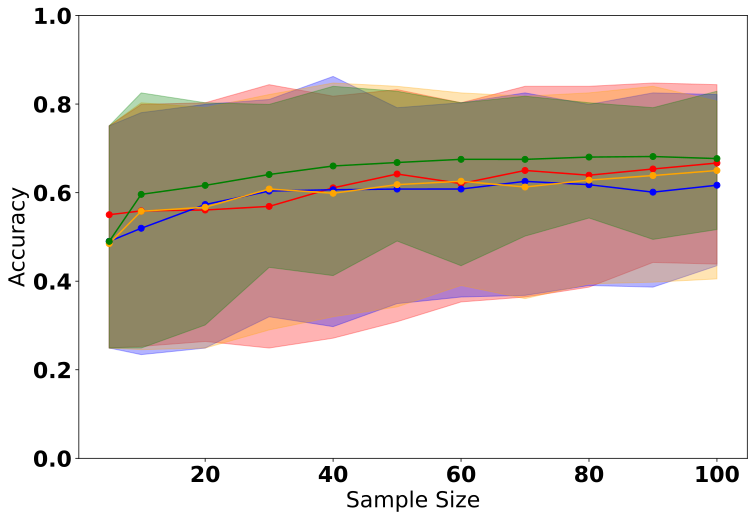

In [2]:
rfaccuracy = pd.read_csv('../casestudy/crc/crcrfaccuracynorm.csv')

crc_data_val = rfaccuracy
# Plotting
# matplotlib.rcParams.update({'font.size': 22})
font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

plt.figure(figsize=(12, 8))
# Plot REAL
plt.plot(crc_data_val['Sample Size'], crc_data_val['Accuracy'],label='Experimental',marker='o', color='red')
plt.fill_between(crc_data_val['Sample Size'], crc_data_val['min'], crc_data_val['max'], color='red', alpha=0.3)


# Plot PP
plt.plot(crc_data_val['Sample Size'], crc_data_val['PP Accuracy'], label='PP',marker='o', color='blue')
plt.fill_between(crc_data_val['Sample Size'], crc_data_val['PP min'], crc_data_val['PP max'], color='blue', alpha=0.3)

# Plot CO
plt.plot(crc_data_val['Sample Size'], crc_data_val['CO Accuracy'], label='CO',marker='o', color='orange')
plt.fill_between(crc_data_val['Sample Size'], crc_data_val['CO min'], crc_data_val['CO max'], color='orange', alpha=0.3)


# Plot TVAE
plt.plot(crc_data_val['Sample Size'], crc_data_val['TVAE Accuracy'], label='TVAE',marker='o', color='green')
plt.fill_between(crc_data_val['Sample Size'], crc_data_val['TVAE min'], crc_data_val['TVAE max'], color='green', alpha=0.3)

# Labels and legend
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')
# plt.title('Accuracy vs Sample Size for Different Methods')
# plt.legend()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Show plot
# plt.grid(True)
plt.ylim(0, 1) 

plt.show()


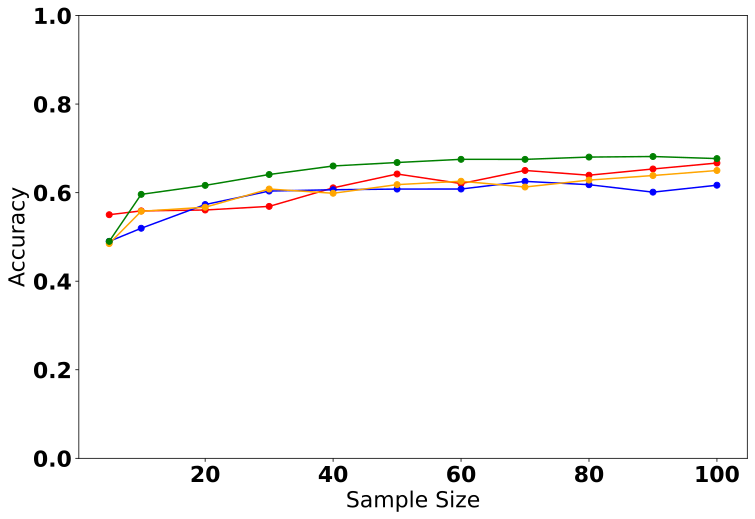

In [5]:
crc_data_val = rfaccuracy
# Plotting
# matplotlib.rcParams.update({'font.size': 22})
font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

plt.figure(figsize=(12, 8))
# Plot REAL
plt.plot(crc_data_val['Sample Size'], crc_data_val['Accuracy'],label='Experimental',marker='o', color='red')
# plt.fill_between(crc_data_val['Sample Size'], crc_data_val['min'], crc_data_val['max'], color='red', alpha=0.3)


# Plot PP
plt.plot(crc_data_val['Sample Size'], crc_data_val['PP Accuracy'], label='PP',marker='o', color='blue')
# plt.fill_between(crc_data_val['Sample Size'], crc_data_val['PP min'], crc_data_val['PP max'], color='blue', alpha=0.3)

# Plot CO
plt.plot(crc_data_val['Sample Size'], crc_data_val['CO Accuracy'], label='CO',marker='o', color='orange')
# plt.fill_between(crc_data_val['Sample Size'], crc_data_val['CO min'], crc_data_val['CO max'], color='orange', alpha=0.3)


# Plot TVAE
plt.plot(crc_data_val['Sample Size'], crc_data_val['TVAE Accuracy'], label='TVAE',marker='o', color='green')
# plt.fill_between(crc_data_val['Sample Size'], crc_data_val['TVAE min'], crc_data_val['TVAE max'], color='green', alpha=0.3)

# Labels and legend
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')
# plt.title('Accuracy vs Sample Size for Different Methods')
# plt.legend()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Show plot
# plt.grid(True)
plt.ylim(0, 1) 

plt.show()


##### Class Discovery

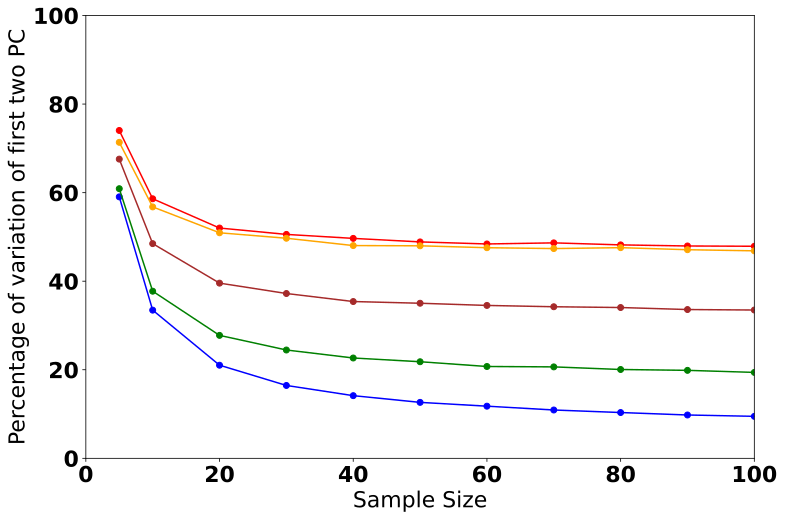

In [6]:
pcaaccuracy = pd.read_csv('../casestudy/crc/crcpca.csv')
crc_data_val = pcaaccuracy
# Plotting
# matplotlib.rcParams.update({'font.size': 22})
font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

plt.figure(figsize=(12, 8))
# Plot REAL
plt.plot(crc_data_val['Sample Size'], crc_data_val['Accuracy'],label='Experimental',marker='o', color='red')
# plt.fill_between(crc_data_val['Sample Size'], crc_data_val['min'], crc_data_val['max'], color='red', alpha=0.3)

plt.plot(crc_data_val['Sample Size'], crc_data_val['Accuracy v'],label='Experimental Validation',marker='o', color='brown')
# plt.fill_between(crc_data_val['Sample Size'], crc_data_val['min v'], crc_data_val['max v'], color='brown', alpha=0.3)


# Plot PP
plt.plot(crc_data_val['Sample Size'], crc_data_val['PP Accuracy'], label='PP',marker='o', color='blue')
# plt.fill_between(crc_data_val['Sample Size'], crc_data_val['PP min'], crc_data_val['PP max'], color='blue', alpha=0.3)

# Plot CO
plt.plot(crc_data_val['Sample Size'], crc_data_val['CO Accuracy'], label='CO',marker='o', color='orange')
# plt.fill_between(crc_data_val['Sample Size'], crc_data_val['CO min'], crc_data_val['CO max'], color='orange', alpha=0.3)


# Plot TVAE
plt.plot(crc_data_val['Sample Size'], crc_data_val['TVAE Accuracy'], label='TVAE',marker='o', color='green')
# plt.fill_between(crc_data_val['Sample Size'], crc_data_val['TVAE min'], crc_data_val['TVAE max'], color='green', alpha=0.3)

# Labels and legend
plt.xlabel('Sample Size')
plt.ylabel('Percentage of variation of first two PC')

plt.ylim(0, 100)
plt.xlim(0,100)
plt.show()


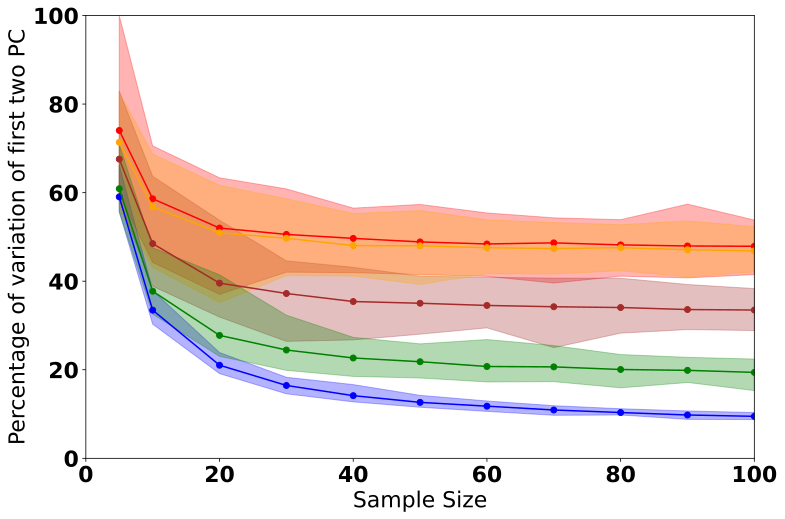

In [7]:
font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

plt.figure(figsize=(12, 8))
# Plot REAL
plt.plot(crc_data_val['Sample Size'], crc_data_val['Accuracy'],label='Experimental',marker='o', color='red')
plt.fill_between(crc_data_val['Sample Size'], crc_data_val['min'], crc_data_val['max'], color='red', alpha=0.3)

plt.plot(crc_data_val['Sample Size'], crc_data_val['Accuracy v'],label='Experimental Validation',marker='o', color='brown')
plt.fill_between(crc_data_val['Sample Size'], crc_data_val['min v'], crc_data_val['max v'], color='brown', alpha=0.3)


# Plot PP
plt.plot(crc_data_val['Sample Size'], crc_data_val['PP Accuracy'], label='PP',marker='o', color='blue')
plt.fill_between(crc_data_val['Sample Size'], crc_data_val['PP min'], crc_data_val['PP max'], color='blue', alpha=0.3)

# Plot CO
plt.plot(crc_data_val['Sample Size'], crc_data_val['CO Accuracy'], label='CO',marker='o', color='orange')
plt.fill_between(crc_data_val['Sample Size'], crc_data_val['CO min'], crc_data_val['CO max'], color='orange', alpha=0.3)


# Plot TVAE
plt.plot(crc_data_val['Sample Size'], crc_data_val['TVAE Accuracy'], label='TVAE',marker='o', color='green')
plt.fill_between(crc_data_val['Sample Size'], crc_data_val['TVAE min'], crc_data_val['TVAE max'], color='green', alpha=0.3)

# Labels and legend
plt.xlabel('Sample Size')
plt.ylabel('Percentage of variation of first two PC')

plt.ylim(0, 100)
plt.xlim(0,100)
plt.show()


##### Class Comparison

In [15]:
adjusted_p_values = {}
adjusted_p_values_pp = {}
adjusted_p_values_co = {}
adjusted_p_values_tvae = {}
dicts = {'real_adjust': adjusted_p_values, 'pp_adjust': adjusted_p_values_pp, 'co_adjust': adjusted_p_values_co, 'tvae_adjust': adjusted_p_values_tvae}  # Add more dictionaries as needed

# Load each JSON file and update the corresponding dictionary
for key, value in dicts.items():
    file_path = f'../casestudy/crc/pval/{key}.json'
    with open(file_path, 'r') as json_file:
        value.update(json.load(json_file))

sample_sizes=[5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]

real = []
pp = []
co = []
tvae = []
realmin = []
realmax = []
ppmin = []
ppmax = []
comin = []
comax = []
tvaemin = []
tvaemax = []

col = 'CP'

for s in sample_sizes:
    s = str(s)
    real.append(np.median(adjusted_p_values[s][col]))
    pp.append(np.median(adjusted_p_values_pp[s][col]))
    co.append(np.median(adjusted_p_values_co[s][col]))
    tvae.append(np.median(adjusted_p_values_tvae[s][col]))
    realmin.append(np.min(adjusted_p_values[s][col]))
    realmax.append(np.max(adjusted_p_values[s][col]))
    ppmin.append(np.min(adjusted_p_values_pp[s][col]))
    ppmax.append(np.max(adjusted_p_values_pp[s][col]))
    comin.append(np.min(adjusted_p_values_co[s][col]))
    comax.append(np.max(adjusted_p_values_co[s][col])) 
    tvaemin.append(np.min(adjusted_p_values_tvae[s][col]))
    tvaemax.append(np.max(adjusted_p_values_tvae[s][col]))


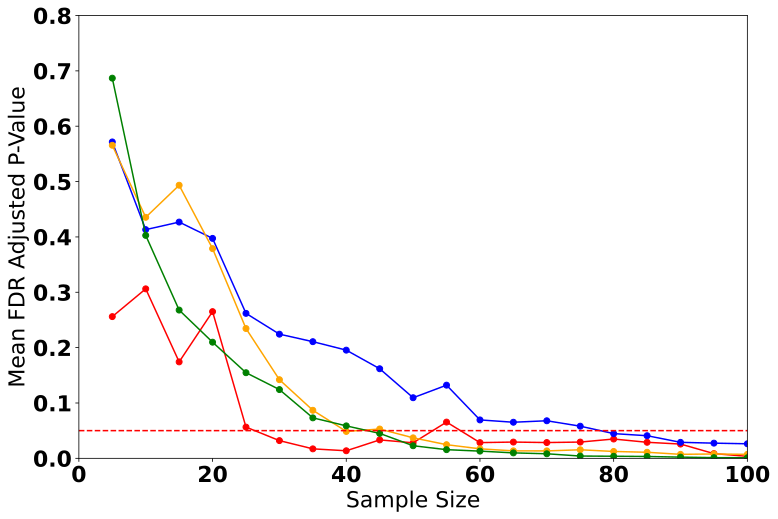

In [16]:
plt.figure(figsize=(12, 8))
font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)
plt.plot(sample_sizes, real, marker='o', label='Experimental', color='red', linestyle='-')
# plt.fill_between(sample_sizes, realmin, realmax, color='red', alpha=0.3)

plt.plot(sample_sizes, pp, marker='o', label='Per-Protein', color='blue', linestyle='-')
# plt.fill_between(sample_sizes, ppmin, ppmax, color='blue', alpha=0.3)

plt.plot(sample_sizes, co, marker='o', label='Copula', color='orange', linestyle='-')
# plt.fill_between(sample_sizes, comin, comax, color='orange', alpha=0.3)

plt.plot(sample_sizes, tvae, marker='o', label='TVAE', color='green', linestyle='-')
# plt.fill_between(sample_sizes, tvaemin, tvaemax, color='green', alpha=0.3)

plt.axhline(y=0.05, color='red', linestyle='--')

plt.xlabel('Sample Size')
plt.ylabel('Mean FDR Adjusted P-Value')

plt.ylim(0.0,0.8)
plt.xlim(0,100)
plt.show()

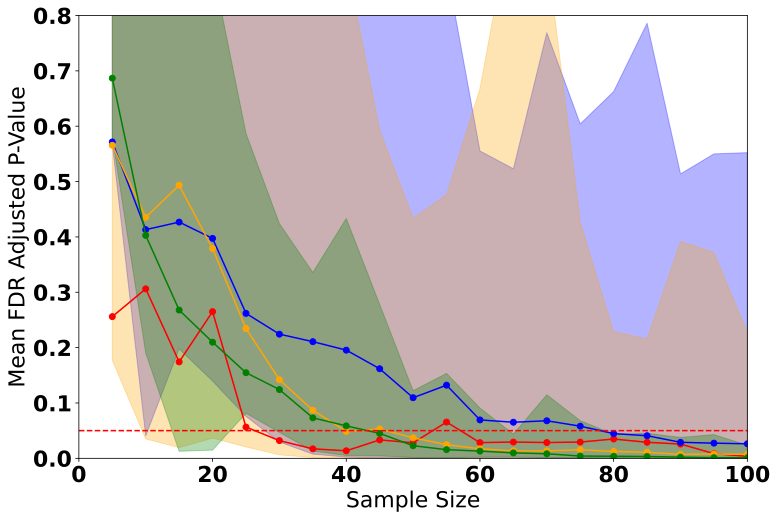

In [17]:
plt.figure(figsize=(12, 8))
font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)
plt.plot(sample_sizes, real, marker='o', label='Experimental', color='red', linestyle='-')
plt.fill_between(sample_sizes, realmin, realmax, color='red', alpha=0.3)

plt.plot(sample_sizes, pp, marker='o', label='Per-Protein', color='blue', linestyle='-')
plt.fill_between(sample_sizes, ppmin, ppmax, color='blue', alpha=0.3)

plt.plot(sample_sizes, co, marker='o', label='Copula', color='orange', linestyle='-')
plt.fill_between(sample_sizes, comin, comax, color='orange', alpha=0.3)

plt.plot(sample_sizes, tvae, marker='o', label='TVAE', color='green', linestyle='-')
plt.fill_between(sample_sizes, tvaemin, tvaemax, color='green', alpha=0.3)

plt.axhline(y=0.05, color='red', linestyle='--')

plt.xlabel('Sample Size')
plt.ylabel('Mean FDR Adjusted P-Value')

plt.ylim(0.0,0.8)
plt.xlim(0,100)
plt.show()